# 🔥 Kaggle House Prices - Advanced Regression Techniques
# Le Wagon Batch Challenge

Welcome to your first Kaggle competition!

Your objective is to **submit online an answer** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

- Fortunately, you have already come across the house dataset in the bootcamp!
- You will be semi-guided up to a **baseline model**
- Only after will you be free to improve & refine your models
- We will approach the problem through **pipelines** (the best practice to take!)

A word on Kaggle:
- Kaggle will rank your submission amongst all participants!
- But don't worry, everyone is publicly removed from the leaderboard after 2 months
- You can make to 10 submissions per day

## Setup Kaggle

👉 Create an account on Kaggle if you want to participate in the competition. 

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

**Your whole class will compete as a group against the team of TAs**

## Kaggle contest rules: Custom metric required
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.

(Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 
- Which performance metric do you need? Is it readily available in sklearn?
- Create a scorer using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) and store it into a variable named `rmsle`
- Create also the negative score `rmsle_neg` which is best when _maximized_. This will come handy later as `GridSearchCV` requires a score to _maximize_

# Imports

- canonical imports
- sklearn   imports
- xgboost   imports

In [155]:
# Canonical imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import math
from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

# sklearn imports

from sklearn import set_config; set_config(display='diagram')

from sklearn.pipeline import Pipeline

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, learning_curve

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor

from sklearn.ensemble import AdaBoostRegressor

# xgboost imports

from xgboost import XGBRegressor

# Datasets loading

- Training data set: (1460, 81) , Testing data set: (1459, 80)
- The training data set has 0 duplicates

We have already downloaded for you everything from Kaggle into your current notebook folder:
- `train.csv` is your (1460 * 81) training set containing `X` and `y`
- `test.csv` is your (1459 * 80) testing set without the associated target `y`!
- `sample_submission.csv` describing the format required to submit your answer
- `data_description.txt` describing all columns

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your test_score & ranking

You can use this direct download link if you don't want to create a Kaggle account

data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv")


In [2]:
# Reading training and test data sets
# Check for duplicates in the training data set >> There are not duplicates

data_train = pd.read_csv("./data/train.csv")
data_test = pd.read_csv("./data/test.csv")

print(f"Training data set: {data_train.shape} , Testing data set: {data_test.shape}")
print(f"The training data set has {len(data_train)-len(data_train.drop_duplicates())} duplicates")

Training data set: (1460, 81) , Testing data set: (1459, 80)
The training data set has 0 duplicates


# Common functions for the baseline and the iterations

**Functions:**
>- def select_features (data_train, y_target, feat_to_be_excluded) return list_of_features
>- def initialize_X_y (data_train, data_test, y_target, X_features) return X_train, y_train, X_test
>- def explore_dtypes (X_train) return cat_features, int_features, float_features
>- def csv_ready_to_submit (df_y_pred, columns_to_write, file_name)
>
>- def rmsle_metric(y_true, y_pred)
>- def rmsle_neg_metric(y_true, y_pred)

**Temporary folder to store the transformers of the pipelines: "cachedir = mkdtemp()"**
>- Transformer parameters can be cached into memory in order to avoid recalculating transformer variables during cross validations and grid searches
>>- Use the Pipeline parameter memory
>>- Clear the cache directory after the cross-validation: "rmtree(cachedir)">

In [151]:
# Selecting the target and the initial set of features for the baseline model
#----------------------------------------------------------------------------
#           target = 'SalePrice'
#           features_excluded = [target] + list_of_ excluded (f.i. features_nulls)
#           features = list(data_train.drop(columns= features_excluded).columns)
#           print(f"Number of features for the baseline model = {len(features)}")

def select_features (data_train, y_target, feat_to_be_excluded):
    ''' y_target: the string name of the column to be predicted''' 
    ''' feat_to_be_excluded: list of column to be drop from the features list '''

    features_excluded = [y_target] + feat_to_be_excluded    
    list_of_features = list(data_train.drop(columns= features_excluded).columns)    
    print(f"Number of features = {len(list_of_features)}")
    
    return list_of_features

# Initializing X, y with training and test data sets
#---------------------------------------------------
#   X_train, y_train for training
#   X_test for testing the performance of the model

def initialize_X_y (data_train, data_test, y_target, X_features):
    ''' data_train: training data set '''
    ''' data_test : test data set ''' 
    ''' y_target  : the string name of the column to be predicted''' 
    ''' X_features: list of features '''
    ''' return: (data_train[features],data_train[target],data_test[features])'''
    
    X_train = data_train[X_features]
    y_train = data_train[y_target]
    X_test = data_test[X_features]
    
    return X_train, y_train, X_test

# Exploring dtypes of features
#---------------------------------------------------
#     print(pd.Series({"Categorical":len(cat_features),
#                      "Integer":len(int_features),
#                      "Float":len(float_features)}))

def explore_dtypes (X_train):
    ''' return 3 lists: categorical_features, int_features, float_features '''
    ''' X_train: training data set '''
    
    df_tmp = pd.DataFrame(X_train.dtypes)

    cat_features = list(df_tmp[df_tmp[0] == 'object'].index)
    int_features = list(df_tmp[df_tmp[0] == 'int64'].index)
    float_features = list(df_tmp[df_tmp[0] == 'float64'].index)

    print(pd.Series({"Categorical":len(cat_features),
                     "Integer":len(int_features),
                     "Float":len(float_features)}))

    return cat_features, int_features, float_features

# Writing the csv ready to be submitted to Kaggle
#---------------------------------------------------
#     df_y_pred is a dataframe with the predictions
#     columns to write according to the Kaggle challenge rules

def csv_ready_to_submit (df_y_pred, columns_to_write, file_name):
    
    df_y_pred.to_csv(file_name,index=False,columns=columns_to_write,mode="w")
    
# rmsle: RMSE between the logarithm of the predicted value and the logarithm of the observed price
# rmsle_neg : -rmsle which is best when maximized through "GridSearchCV" 
# RMSE stands for Root-Mean-Squared-Error

def rmsle_metric(y_true, y_pred):
    
    y_true_log = pd.Series(y_true).apply(lambda x: math.log(x))
    y_pred_log = pd.Series(y_pred).apply(lambda x: math.log(x))
    
    return mean_squared_error (y_true_log, y_pred_log, squared=False )

def rmsle_neg_metric(y_true, y_pred):
    
    y_true_log = pd.Series(y_true).apply(lambda x: math.log(x))
    y_pred_log = pd.Series(y_pred).apply(lambda x: math.log(x))
    
    return - mean_squared_error (y_true_log, y_pred_log, squared=False )

rmsle = make_scorer(rmsle_metric, greater_is_better=False)
rmsle_neg = make_scorer(rmsle_neg_metric, greater_is_better=True)

In [4]:
# Create a temporary folder to store the transformers of the pipelines
# Transformer parameters can be cached into memory
# Avoid recalculating transformer variables during cross validations or grid searches
# Only helps when transformer fit time is long and dataset very large
# Use the Pipeline parameter memory
# Clear the cache directory after the cross-validation: rmtree(cachedir)

cachedir = mkdtemp()


# 🐣 BASELINE

## Preparing the initial data for the baseline:  "preproc_baseline"

Exclusion of categorical features with more than 6 unique values 
>- Categorical features in the dataset         43
>-    Categorical features included          34
>>Simple-Impute with most frequent values and One-Hot-Encode (Drop all others features)
>-    Categorical features excluded           9
>>['Neighborhood', 'Exterior2nd', 'Exterior1st', 'SaleType', 'Condition1', 'Condition2', 'HouseStyle', 'RoofMatl', 'Functional']

Numerical features
>- Simple-Impute with strategy 'mean'
>- Min-Max Scale 

In [5]:
# Initializing X, y with training and test data sets
#   X_train, y_train for training
#   X_test for testing the performance of the model

target = 'SalePrice'
feat_to_be_excluded = []

features_base = select_features (data_train, target, feat_to_be_excluded )

X_train, y_train, X_test = initialize_X_y(data_train, data_test, target, features_base)

print(f"X_train.shape{X_train.shape}\ny_train.shape {y_train.shape}\nX_test.shape {X_test.shape}")

# Exploring dtypes of features

cat_features_base, int_features_base, float_features_base = explore_dtypes (X_train)

num_features_base = int_features_base + float_features_base

Number of features = 80
X_train.shape(1460, 80)
y_train.shape (1460,)
X_test.shape (1459, 80)
Categorical    43
Integer        34
Float           3
dtype: int64


80 features is too much to deal with one-by-one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have?

❓ Store the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total ?

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and spare, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with 50-100 features max (📚 Read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

There are 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

💡 As a starter, what about simply removing all features that have **7 unique values or more**, and one-hot-encode every others? Let's keep ordinal encoding and statistical feature selection for the next iteration.

❓ Store features to OHE in a list `feat_categorical_small` below. How many features will be OHE?

--------------------------------------------------------------------
Total number of unique values for the categorical features = 252
--------------------------------------------------------------------


<AxesSubplot:ylabel='Count'>

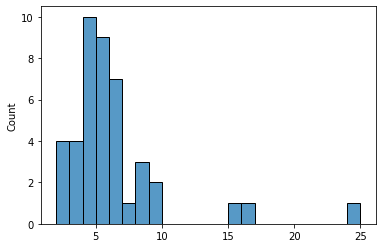

In [6]:
# Exploring unique_values for categorical features
# cat_features_unique_values[feature] = number of unique values of the feature excluding np.nan

cat_features_unique_values = {}

for feat in cat_features_base:
    cat_features_unique_values[feat] = pd.Series(data_train[feat].unique()).notnull().sum()
 
feat_categorical_nunique_base = pd.Series(cat_features_unique_values).sort_values(ascending=False)

print("--------------------------------------------------------------------")
print(f"Total number of unique values for the categorical features = \
{feat_categorical_nunique_base.sum()}\n--------------------------------------------------------------------")

# Histogram of number of unique value per categorical feature

sns.histplot(feat_categorical_nunique_base, binwidth=1)

In [7]:
# Classifying categorical features based on their number of unique values

UNIQUE_VALUES_THRESHOLD = 7

feat_categorical_small_base = list(feat_categorical_nunique_base
                              [feat_categorical_nunique_base < UNIQUE_VALUES_THRESHOLD].index)

feat_categorical_large_base = list(feat_categorical_nunique_base 
                              [feat_categorical_nunique_base >= UNIQUE_VALUES_THRESHOLD].index)

cat_features_nunique_base = pd.Series({
                                  "Categorical features in the dataset":len(feat_categorical_nunique_base), 
                                  "Categorical features included"      :len(feat_categorical_small_base),
                                  "Categorical features excluded"      :len(feat_categorical_large_base)
                                    })

# feat_categorical_nunique[feat_categorical_small]

feat_categorical_small = feat_categorical_small_base

print("---------------------------------------------------------------------------------")
print(f"Categorical features excluded due to having more than 6 unique values \n{feat_categorical_large_base}")
print("---------------------------------------------------------------------------------")

cat_features_nunique_base

---------------------------------------------------------------------------------
Categorical features excluded due to having more than 6 unique values 
['Neighborhood', 'Exterior2nd', 'Exterior1st', 'SaleType', 'Condition1', 'Condition2', 'HouseStyle', 'RoofMatl', 'Functional']
---------------------------------------------------------------------------------


Categorical features in the dataset    43
Categorical features included          34
Categorical features excluded           9
dtype: int64

🧪 Test your code below (and clear the cell once it passed)

In [8]:
from nbresult import ChallengeResult
result = ChallengeResult('features_overview',
    n=len(feat_categorical_small))
result.write(); print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.1, py-1.10.0, pluggy-0.13.1 -- /home/jm/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8
cachedir: .pytest_cache
rootdir: /home/jm/code/JPDZ67/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: anyio-2.0.2
collecting ... collected 1 item

tests/test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master


In [9]:
# Numerical features: Simple-Impute with strategy 'mean' and Min-Max Scale

num_transform_pipe_base = \
                Pipeline([ ('num_imputer', SimpleImputer(strategy="mean")),
                ('num_scaler', MinMaxScaler()) ], memory = cachedir)

# Categorical features: Simple-Impute with most frequent values and OHE "feat_categorical_small"

cat_transform_pipe_base = \
                Pipeline([ ('cat_imputer', SimpleImputer(strategy="most_frequent")),
                ('cat_transformer', OneHotEncoder(handle_unknown='ignore',sparse=False)) ],
                memory = cachedir)

# For categorical features OHE only if they have less than 7 unique values, otherwise drop them

preproc_baseline = \
                ColumnTransformer([('num_transformer', num_transform_pipe_base, num_features_base),
                ('cat_transformer', cat_transform_pipe_base, feat_categorical_small_base) ])

preproc_baseline

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(memory='/tmp/tmp4dt566r5',
                                          steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  MinMaxScaler())]),
                                 ['Id', 'MSSubClass', 'LotArea', 'OverallQual',
                                  'OverallCond', 'YearBuilt', 'YearRemodAdd',
                                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                                  'LowQualFinSF', 'GrLivArea', 'BsmtFul...
                                 ['BsmtFinType2', 'Heating', 'RoofStyle',
                                  'SaleCondition', 'BsmtFinType1', 'GarageType',
                                  'Foundation', 'Electrical', 'FireplaceQu',
                                  'HeatingQC', 'GarageQual', 'GarageCond',
                                  'MSZoning', 'LotConfig', 'ExterCond',
                                  'BldgType', 'BsmtExposure', 'MiscFeature',
                                  'Fence', 'LotShape', 'LandContour',
                                  'BsmtCond', 'KitchenQual', 'MasVnrType',
                                  'ExterQual', 'BsmtQual', 'LandSlope',
                                  'GarageFinish', 'PavedDrive', 'PoolQC', ...])])

❓ Look at the **shape** of your preprocessed dataframe.

In [10]:
shape_preproc_baseline = pd.DataFrame(preproc_baseline.fit_transform(X_train)).shape
shape_preproc_baseline

(1460, 184)

🧪 Test your code below

In [11]:
from nbresult import ChallengeResult
result = ChallengeResult('preproc_baseline',
    shape=shape_preproc_baseline)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.1, py-1.10.0, pluggy-0.13.1 -- /home/jm/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8
cachedir: .pytest_cache
rootdir: /home/jm/code/JPDZ67/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: anyio-2.0.2
collecting ... collected 1 item

tests/test_preproc_baseline.py::TestPreprocBaseline::test_shape PASSED   [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/preproc_baseline.pickle

git commit -m 'Completed preproc_baseline step'

git push origin master


## Model baseline


### Ridge Regressor >> rmsle score for the baseline= 0.16631913339626253
 
>- Pipe a basic Ridge regressor to your `preproc_baseline` and store it to `pipe_baseline` variable.
>- 5-fold cross_validate your pipe_baseline using this metric to get a first glance at your baseline perf.
Store your mean score as score_baseline


In [12]:
pipe_baseline = Pipeline([ ('transformer', preproc_baseline),('regressor', Ridge()) ],
                         memory = cachedir)
pipe_baseline

Pipeline(memory='/tmp/tmp4dt566r5',
         steps=[('transformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(memory='/tmp/tmp4dt566r5',
                                                           steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Id', 'MSSubClass',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF',...
                                                   'BsmtFinType1', 'GarageType',
                                                   'Foundation', 'Electrical',
                                                   'FireplaceQu', 'HeatingQC',
                                                   'GarageQual', 'GarageCond',
                                                   'MSZoning', 'LotConfig',
                                                   'ExterCond', 'BldgType',
                                                   'BsmtExposure',
                                                   'MiscFeature', 'Fence',
                                                   'LotShape', 'LandContour',
                                                   'BsmtCond', 'KitchenQual',
                                                   'MasVnrType', 'ExterQual',
                                                   'BsmtQual', 'LandSlope',
                                                   'GarageFinish', 'PavedDrive',
                                                   'PoolQC', ...])])),
                ('regressor', Ridge())])

In [153]:
cv_results = cross_validate(pipe_baseline, X_train, y_train, cv=5, scoring=rmsle_neg)

rmtree(cachedir)

score_baseline = - cv_results['test_score'].mean()

print("---------------------------------------------------")
print(f" rmsle score for the baseline= {score_baseline}")
print("---------------------------------------------------")

---------------------------------------------------
 rmsle score for the baseline= 0.16632066236540652
---------------------------------------------------


## Predict baseline

- Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.
- Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. Read carefully the Kaggle required format and test it below (you don't need to submit this baseline online for now).

>**Submission File Format**: The file should contain a header and have the following format:
>
>|Id|SalePrice|
>| :- |---|
>|1461|169000.1|
>|1462|187724.1233|
>|1463|175221|
>|etc.|etc.|

You can use this direct download link if you don't want to create a Kaggle account
- X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")

In [14]:
# Let's fit with the whole training data set

pipe_baseline.fit(X_train, y_train)
rmtree(cachedir)

# Let's create a dataframe with the predictions for the test data set

y_pred_baseline = pd.DataFrame(pipe_baseline.predict(X_test)).rename(columns={0:'SalePrice'})
y_pred_baseline["Id"] = X_test["Id"]
y_pred_baseline.head()

,SalePrice,Id
0,112477.540571,1461
1,135486.397394,1462
2,173832.726703,1463
3,189339.042316,1464
4,186263.296279,1465


In [15]:
# df.to_csv("./data/submission_baseline.csv",index=False,columns=columns_to_write,mode="w")

columns_to_write = ["Id","SalePrice"]
file_name = "./data/submission_baseline.csv"

csv_ready_to_submit (y_pred_baseline, columns_to_write, file_name)

🧪 Test your code

In [16]:
from nbresult import ChallengeResult
tmp = pd.read_csv("data/submission_baseline.csv")
result = ChallengeResult('submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.1, py-1.10.0, pluggy-0.13.1 -- /home/jm/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8
cachedir: .pytest_cache
rootdir: /home/jm/code/JPDZ67/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: anyio-2.0.2
collecting ... collected 4 items

tests/test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.11s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baseline step'

git push origin mas

# 🏋️‍♀️ ITERATIONS

- Preprocessing data
- Models iteration
>- Ridge
>- SVR, AdaBoost(SVR)
>- Decision Tree Regression
>- AdaBoost (DecisionTreeRegressor)
>- GradientBoostingRegressor
>- xgboost
- Make the prediction with VotingRegressor ( stacking all the models with different weights )

## Preprocessing: "preproc_iteration_2"

**Features**
>- Excluding 5 features with 40% or more of nan values
>- Ordinal encoding of 16 categorical features
>- OHE of 13 categorical features
>- Statistical Feature Selection  *"SelectPercentile(score_func= mutual_info_regression, percentile=80)"*

**Target**
>- We transform our target to directly predict its log.
>- Normally distributed variables should be easier to predict with linear models.



### Excluding features with 40% or more of nan values

>- Features with at least 40.0% of null values: ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
>- Delta score vs baseline = 0.0020853932834377364


In [17]:
# features_too_nulls = List of features with 40% or more of nan values

NAN_THRESHOLD = 0.4

df_tmp = pd.DataFrame(data_train.isnull().sum().sort_values(ascending=False)/len(data_train))
features_too_nulls = list(df_tmp [df_tmp >= NAN_THRESHOLD].dropna().index)

print(f"Features with at least {NAN_THRESHOLD*100}% of null values:\n{features_too_nulls}")

Features with at least 40.0% of null values:
['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


In [19]:
# Initializing X, y with training and test data sets excluding the list of features_nulls and feat_categorical_large_base
#   X_train, y_train for training
#   X_test for testing the performance of the model
#   features_too_nulls = List of features with 50% or more of nan values
#   feat_categorical_large_base = features with more than 6 unique values

target = 'SalePrice'
feat_to_be_excluded = feat_categorical_large_base + features_too_nulls

features_iter_1 = select_features (data_train, target, feat_to_be_excluded )

X_train_1, y_train_1, X_test_1 = initialize_X_y(data_train, data_test, target, features_iter_1)

# Building list of columns to be transformed according to dtypes and exclusion rules 
#   X_train_1, y_train_1 for training iteration 1
#   X_test_1 for testing the performance of the model iteration 1

print(f"X_train_1.shape {X_train_1.shape}, y_train_1.shape {y_train_1.shape},\
X_test_1.shape {X_test_1.shape}")

cat_features_1, int_features_1, float_features_1 = explore_dtypes (X_train_1)
num_features_1 = int_features_1 + float_features_1

Number of features = 66
X_train_1.shape (1460, 66), y_train_1.shape (1460,),X_test_1.shape (1459, 66)
Categorical    29
Integer        34
Float           3
dtype: int64


In [23]:
# Numerical features: Simple-Impute with strategy 'mean' and Min-Max Scale

num_transform_pipe_1 = Pipeline([ ('num_imputer', SimpleImputer(strategy="mean")),
                                ('num_scaler', MinMaxScaler()) ],
                               memory=cachedir)

# Categorical features: Simple-Impute with most frequent values and OHE "feat_categorical_small"

cat_transform_pipe_1 = Pipeline([ ('cat_imputer', SimpleImputer(strategy="most_frequent")),
                                  ('cat_transformer', OneHotEncoder(handle_unknown='ignore',sparse=False)) ],
                                  memory=cachedir)

# For categorical features OHE only if they have less than 7 unique values, otherwise drop them

preproc_iteration_1 = ColumnTransformer( [ ('num_transformer', num_transform_pipe_1, num_features_1),
                                           ('cat_transformer', cat_transform_pipe_1, cat_features_1)])

preproc_iteration_1

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(memory='/tmp/tmp4dt566r5',
                                          steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  MinMaxScaler())]),
                                 ['Id', 'MSSubClass', 'LotArea', 'OverallQual',
                                  'OverallCond', 'YearBuilt', 'YearRemodAdd',
                                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                                  'LowQualFinSF', 'GrLivArea', 'BsmtFul...
                                 ['MSZoning', 'Street', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'GarageType', 'GarageFinish', 'GarageQual',
                                  'GarageCond', 'PavedDrive',
                                  'SaleCondition'])])

In [24]:
pipe_iteration_1 = Pipeline([ ('transformer', preproc_iteration_1),('regressor', Ridge()) ],
                           memory=cachedir)
pipe_iteration_1

Pipeline(memory='/tmp/tmp4dt566r5',
         steps=[('transformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(memory='/tmp/tmp4dt566r5',
                                                           steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Id', 'MSSubClass',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF',...
                                                   'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig',
                                                   'LandSlope', 'BldgType',
                                                   'RoofStyle', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'GarageType', 'GarageFinish',
                                                   'GarageQual', 'GarageCond',
                                                   'PavedDrive',
                                                   'SaleCondition'])])),
                ('regressor', Ridge())])

In [25]:
cv_results_1 = cross_validate(pipe_iteration_1, X_train_1, y_train_1, cv=5, scoring=rmsle)

rmtree(cachedir)

score_improvement_iter1 = cv_results_1['test_score'].mean() - score_baseline
print(f"Delta score vs baseline = {score_improvement_iter1}")

Delta score vs baseline = 0.002578876862761731


### Encoding categorical features: "transform_iteration_2"

- 16 categorical features to be ordinally encoded
>['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', >'HeatingQC', 'KitchenQual', 'CentralAir', 'GarageQual', 'GarageCond', 'GarageFinish', 'PavedDrive']
- 13 categorical features to be OHE
>['MSZoning', 'Street', 'Utilities', 'LotConfig', 'BldgType', 'RoofStyle', 'MasVnrType', 'Foundation', 'BsmtExposure', 'Heating', 'Electrical', 'GarageType', 'SaleCondition']

In [167]:
cat_ordinal_2 = ["LotShape","LandContour","LandSlope","ExterQual","ExterCond","BsmtQual",
                "BsmtCond","BsmtFinType1","BsmtFinType2","HeatingQC","KitchenQual",
                "CentralAir","GarageQual","GarageCond","GarageFinish","PavedDrive"]

# Define specific order to ordinally encode some categorical features
# Ordered from worst to best in terms of quality

LotShape_sorted_values = [ 'IR3' , 'IR2', 'IR1', 'Reg'] 
LandContour_sorted_values = [ 'Low' , 'HLS', 'Bnk', 'Lvl']
LandSlope_sorted_values = [ 'Sev' , 'Mod', 'Gtl']
ExterQual_sorted_values = [ 'Po' , 'Fa', 'TA', 'Gd', 'Ex']
ExterCond_sorted_values = [ 'Po' , 'Fa', 'TA', 'Gd', 'Ex']
BsmtQual_sorted_values = [ 'NA', 'Po' , 'Fa', 'TA', 'Gd', 'Ex']
BsmtCond_sorted_values = [ 'NA', 'Po' , 'Fa', 'TA', 'Gd', 'Ex']
BsmtFinType1_sorted_values = [ 'NA', 'Unf' , 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
BsmtFinType2_sorted_values = [ 'NA', 'Unf' , 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
HeatingQC_sorted_values = [ 'Po' , 'Fa', 'TA', 'Gd', 'Ex']
KitchenQual_sorted_values = [ 'Po' , 'Fa', 'TA', 'Gd', 'Ex']
CentralAir_sorted_values = [ 'N' , 'Y']
GarageQual_sorted_values = [ 'NA', 'Po' , 'Fa', 'TA', 'Gd', 'Ex']
GarageCond_sorted_values = [ 'NA', 'Po' , 'Fa', 'TA', 'Gd', 'Ex']
GarageFinish_sorted_values = [ 'NA', 'Unf' , 'RFn', 'Fin']
PavedDrive_sorted_values = [ 'N' , 'P', 'Y']

categories_2=[LotShape_sorted_values, 
            LandContour_sorted_values,
            LandSlope_sorted_values,
            ExterQual_sorted_values,
            ExterCond_sorted_values,
            BsmtQual_sorted_values,
            BsmtCond_sorted_values,
            BsmtFinType1_sorted_values,
            BsmtFinType2_sorted_values,
            HeatingQC_sorted_values,
            KitchenQual_sorted_values,
            CentralAir_sorted_values,
            GarageQual_sorted_values,
            GarageCond_sorted_values,
            GarageFinish_sorted_values,
            PavedDrive_sorted_values]

# Segmentation of features iteration 2
#     num_features_2 = numerical
#     cat_ordinal_2  = categorical to be ordinal encoding
#     cat_OHE_2      = categorical to be One Hot Encoding

num_features_2 = num_features_1

cat_OHE_2 = list(pd.DataFrame(cat_features_1).set_index(0).drop(index=cat_ordinal_2).index)

print("-----------------------------------------------")
print(f"{len(cat_features_1)} categorical features to be encoded")
print("-----------------------------------------------")
print(f"{len(cat_OHE_2)} categorical features to be OHE\n\n{cat_ordinal_2}")
print("-----------------------------------------------")
print(f"{len(cat_ordinal_2)} categorical features to be ordinally encoded\n\n{cat_OHE_2}")
print("-----------------------------------------------")

-----------------------------------------------
29 categorical features to be encoded
-----------------------------------------------
13 categorical features to be OHE

['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'CentralAir', 'GarageQual', 'GarageCond', 'GarageFinish', 'PavedDrive']
-----------------------------------------------
16 categorical features to be ordinally encoded

['MSZoning', 'Street', 'Utilities', 'LotConfig', 'BldgType', 'RoofStyle', 'MasVnrType', 'Foundation', 'BsmtExposure', 'Heating', 'Electrical', 'GarageType', 'SaleCondition']
-----------------------------------------------


In [34]:
# Encoding of features iteration 2
#     num_features_2 = numerical
#     cat_OHE_2      = categorical features to be One Hot Encoding
#     cat_ordinal_2  = categorical features to be ordinal encoding
#     categories_2   = order of encoding for the cat_ordinal_2 features  

# Preparation of data sets for iteration 2

features_iter_2 = num_features_2, cat_ordinal_2, cat_OHE_2
X_train_2, y_train_2, X_test_2 = initialize_X_y(data_train, data_test, target, features_iter_1)

# Encoder for categorical features

cat_ord_encoder = Pipeline([ ('cat_imputer', SimpleImputer(strategy="most_frequent")),
                              ('cat_encoder', OrdinalEncoder(categories= categories_2,
                              handle_unknown="use_encoded_value",unknown_value=-1)) ],
                          memory=cachedir)

cat_OHE_encoder = Pipeline([ ('cat_imputer', SimpleImputer(strategy="most_frequent")),
                              ('cat_encoder', OneHotEncoder(handle_unknown='ignore',sparse=False)) ],
                          memory=cachedir)

# Encoder for numerical features

num_transform_pipe_2 = Pipeline([ ('num_imputer', SimpleImputer(strategy="mean")),
                                ('num_scaler', MinMaxScaler()) ],
                               memory=cachedir)

# Preprocessor for iteration 2

transform_iteration_2 = ColumnTransformer( [ ('cat_ord_encoding', cat_ord_encoder, cat_ordinal_2),
                                           ('cat_OHE_encoding', cat_OHE_encoder, cat_OHE_2),
                                           ('num_tranformation', num_transform_pipe_2, num_features_2)
                                         ] )

transform_iteration_2

ColumnTransformer(transformers=[('cat_ord_encoding',
                                 Pipeline(memory='/tmp/tmp4dt566r5',
                                          steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OrdinalEncoder(categories=[['IR3',
                                                                              'IR2',
                                                                              'IR1',
                                                                              'Reg'],
                                                                             ['Low',
                                                                              'HLS',
                                                                              'Bnk',
                                                                              'Lvl'],
                                                                             ['Sev',
                                                                              'Mod',
                                                                              'Gtl'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['NA',
                                                                              'Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],...
                                  'OverallCond', 'YearBuilt', 'YearRemodAdd',
                                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                                  'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
                                  'BsmtHalfBath', 'FullBath', 'HalfBath',
                                  'BedroomAbvGr', 'KitchenAbvGr',
                                  'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
                                  'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                                  'EnclosedPorch', '3SsnPorch', 'ScreenPorch', ...])])

### Statistical Feature Selection: "preproc_iteration_2" 

- We use sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) tools directly in the pipeline.We add a `SelectPercentile` filter (coupled with `mutual_info_regression` for the statistical test to use) at the end of the `preproc` pipeline. This will filter-out features that, taken individually, least explain the target!  
>SelectPercentile(score_func= mutual_info_regression, percentile=80)
>
>*-This will recursively filter-out least important features according to `feature_permutation` importance!*  

 <details> 
    <summary> Other options would be (click to expand):</summary>
    
    >*- Multivariate feature selection based their common relationship with target `y`*
    
    >*- Filter based only on the properties of `X`. Use Pearson's correlation combined with a heatmap...to check visually whether some numerical features almost entirely explain others.Then, create a "filter" in your pipeline that removes any correlated below a certain threshold*
    
    >*- Use Spearman's rank correlation combined with a heatmap...to whether some ordinally encoded features are almost entirely "ordered" similarily than others. Then, create a "filter" in your pipeline that removes any ordinal features correlated below a certain threshold*
    
    >*- Another way to filter out feature relies solely on removing those with the lowest variance.Think about it: a feature which only takes one value is useless (and has a variance of 0).Try to add a `VarianceThreshold` to the end of your pipeline*
</details>

In [166]:
select_perc = SelectPercentile(score_func= mutual_info_regression, percentile=80)

preproc_iteration_2 = Pipeline([ ('transformer', transform_iteration_2),('selector', select_perc) ],
                              memory=cachedir)

preproc_iteration_2

Pipeline(memory='/tmp/tmp4dt566r5',
         steps=[('transformer',
                 ColumnTransformer(transformers=[('cat_ord_encoding',
                                                  Pipeline(memory='/tmp/tmp4dt566r5',
                                                           steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OrdinalEncoder(categories=[['IR3',
                                                                                               'IR2',
                                                                                               'IR1',
                                                                                               'Reg'],
                                                                                              ['Low',
                                                                                               'HLS',
                                                                                               'Bnk',
                                                                                               'Lvl'],
                                                                                              ['Sev',
                                                                                               'Mod',
                                                                                               'Gtl'],
                                                                                              ['Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['...
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageCars', 'GarageArea',
                                                   'WoodDeckSF', 'OpenPorchSF',
                                                   'EnclosedPorch', '3SsnPorch',
                                                   'ScreenPorch', ...])])),
                ('selector',
                 SelectPercentile(percentile=80,
                                  score_func=<function mutual_info_regression at 0x7f87dff9e550>))])

#### Final preproc pipeline

>- Baseline rmsle => score_baseline
>- preproc pipeline => preproc_iteration_2
>- target => y_log_train_2
>- training data set => X_train_2
>- score function: rmsle_log, rmsle_log_neg
>- predictions => exp( y_log_pred )

### Target engineering 

- We are asked to minimize the RMSLE. Why don't we transform our target to directly predict its log?
>**Normally distributed variables should be easier to predict with linear models**
>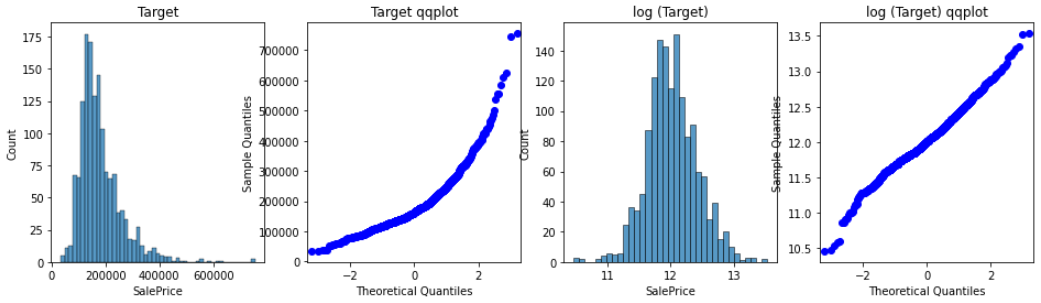

- Let's create `y_log` and the new performance metrics. 
>- y_log_train = pd.Series(y_train).apply(lambda x: math.log(x))
>- def rmsle_log_metric(y_true, y_pred)
>- def rmsle_log_neg_metric(y_true, y_pred)

- At the end, we have to take the exponential of the predictions!
>- y_test_pred = pd.Series(best_model.predict(X_test)).apply(lambda y: math.exp(y))

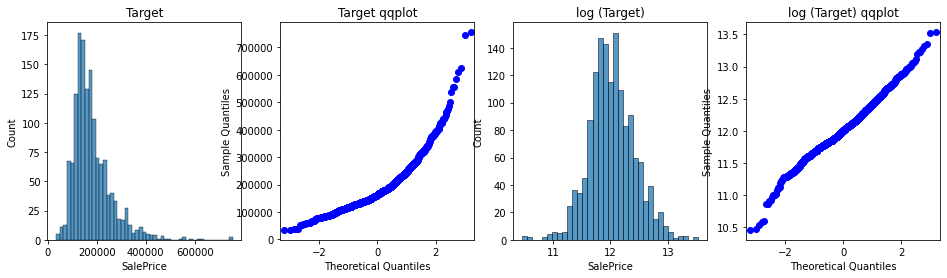

In [168]:
# Create y_log and new performance metrics
# Don't forget at the end to take the exponential of your predictions!

y_log_train_2 = pd.Series(y_train_2).apply(lambda x: math.log(x))

fig, axes = plt.subplots(1,4,figsize=(16,4)) 
sns.histplot(y_train_2, ax=axes[0])
axes[0].set_title("Target")
sm.qqplot(y_train_2, ax=axes[1])
axes[1].set_title("Target qqplot")
sns.histplot(y_log_train_2, ax=axes[2])
axes[2].set_title("log (Target)")
sm.qqplot(y_log_train_2, ax=axes[3])
axes[3].set_title("log (Target) qqplot")
plt.show()

In [154]:
# rmsle_log: RMSE between the logarithm of the predicted value and the logarithm of the observed price
# rmsle_log_neg : -rmsle which is best when maximized through "GridSearchCV" 
# RMSE stands for Root-Mean-Squared-Error

def rmsle_log_metric(y_true, y_pred):
    
    return mean_squared_error (y_true, y_pred, squared=False )

def rmsle_log_neg_metric(y_true, y_pred):
    
    return - mean_squared_error (y_true, y_pred, squared=False )

rmsle_log = make_scorer(rmsle_log_metric, greater_is_better=False)
rmsle_log_neg = make_scorer(rmsle_log_neg_metric, greater_is_better=True)

## Models Iteration

**Regression models** 
>- Decision Tree Regression
>- Ridge
>- SVR
>##### Let's try to reduce the bias by using some boosting ensemble methods
>There is not overfitting (bagging is not needed)*
>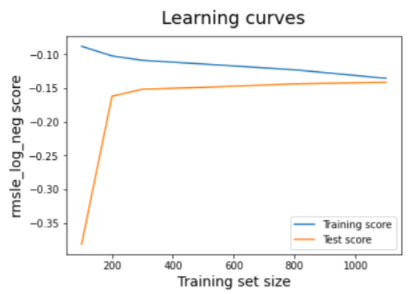

**Boosting**
>- AdaBoost(SVR)
>- AdaBoost (DecisionTreeRegressor)
>- GradientBoostingRegressor
>- xgboost

**Stacking ensemble method to make the predictions**
>- VotingRegressor

### Model 1 : Ridge

- Model 1: rmsle score = 0.14359082351411573, Delta vs baseline = -0.022728309882146802
- Model 1: params {'regressor__alpha': 2.705697399060696}

In [50]:
pipe_baseline_ridge = Pipeline([ ('transformer', preproc_iteration_2),('regressor', Ridge(alpha=1)) ],
                              memory=cachedir)

cv_ridge = cross_validate(pipe_baseline_ridge, X_train_2, y_log_train_2, cv=5, scoring=rmsle_log_neg)

rmtree(cachedir)

model1_score = - cv_ridge['test_score'].mean() 
print(f"Model 1: rmsle score = {model1_score}, Delta vs baseline = {model1_score - score_baseline}")

Model 1: rmsle score = 0.14460668965055126, Delta vs baseline = -0.02171244374571127


In [53]:
grid_model1 = {'regressor__alpha': stats.loguniform(0.01, 3)}

search_model1 = RandomizedSearchCV(pipe_baseline_ridge, grid_model1,cv = 5, n_iter= 100, scoring=rmsle_log_neg, n_jobs=-1)
search_model1.fit(X_train_2, y_log_train_2)

rmtree(cachedir)

In [54]:
model1_score = - search_model1.best_score_
print(f"Model 1: rmsle score = {model1_score}, Delta vs baseline = {model1_score - score_baseline}")
print(f"Model 1: params {search_model1.best_params_}")

Model 1: rmsle score = 0.14359082351411573, Delta vs baseline = -0.022728309882146802
Model 1: params {'regressor__alpha': 2.705697399060696}


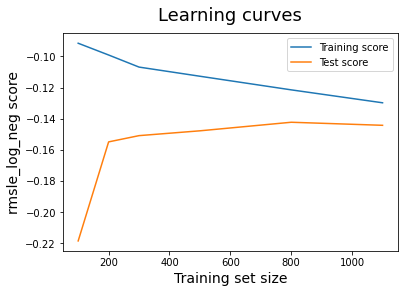

In [59]:
## Learning curves of search_model1.best_estimator_

estimator_model1 = search_model1.best_estimator_

train_sizes = [100, 200, 300, 500, 800, 1100]

# Get train scores, train sizes, and validation scores using `learning_curve`

y_log_train = pd.Series(y_train).apply(lambda x: math.log(x))

train_sizes, train_scores, test_scores = \
         learning_curve(estimator=estimator_model1, X=X_train, y=y_log_train, 
                        scoring=rmsle_log_neg, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('rmsle_log_neg score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

### Model 2.a : Support Vector Regression

- Model 2a: rmsle score = 0.14022233241160953, Delta vs baseline = -0.02609832995379699
- Model 2a best params => {'regressor__C': 0.24626481244539566, 'regressor__epsilon': 0.08747649515484607, 'regressor__kernel': 'linear'}

In [55]:
pipe_baseline_svr = Pipeline([ ('transformer', preproc_iteration_2),('regressor', SVR()) ],
                            memory=cachedir)

cv_svr = cross_validate(pipe_baseline_svr, X_train_2, y_log_train_2, cv=5, scoring=rmsle_log_neg)

rmtree(cachedir)

model2_score = - cv_svr['test_score'].mean() 
print(f"Model 2: rmsle score = {model2_score}, Delta vs baseline = {model2_score - score_baseline}")

Model 2: rmsle score = 0.1450145126057219, Delta vs baseline = -0.02130462079054063


In [56]:
grid_model2 = {'regressor__C': stats.uniform(-1.0,2.0),
               'regressor__epsilon': stats.loguniform(0.01, 2),
               'regressor__kernel': ["linear", "rbf"] }

search_model2 = RandomizedSearchCV(pipe_baseline_svr, grid_model2,cv = 5, n_iter= 200, scoring=rmsle_log_neg, n_jobs=-1)
search_model2.fit(X_train_2, y_log_train_2)

rmtree(cachedir)

/home/jm/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [        nan         nan -0.1475468          nan -0.14068847         nan
         nan         nan -0.33475017         nan         nan         nan
 -0.14472097         nan         nan -0.15308498 -0.1430556  -0.14196137
         nan         nan         nan         nan -0.15103201 -0.28630544
         nan -0.15348288 -0.14410914         nan -0.16116044         nan
 -0.39992264 -0.1519559  -0.33208149 -0.14155644 -0.14530356         nan
         nan         nan -0.16633725 -0.38101532         nan -0.16971259
 -0.14432394 -0.14641123 -0.16878523         nan -0.16912782         nan
         nan         nan         nan -0.22661821         nan         nan
 -0.20481618 -0.14434726 -0.29207127         nan -0.14446078         nan
 -0.15781293 -0.16684081 -0.15761957         nan         nan         nan
         nan         nan 

In [57]:
model2_score = - search_model2.best_score_

print(f"Model 2: rmsle score = {model2_score}, Delta vs baseline = {model2_score - score_baseline}")
print(f"Model 2 best params => {search_model2.best_params_}")

Model 2: rmsle score = 0.14068846755093073, Delta vs baseline = -0.0256306658453318
Model 2 best params => {'regressor__C': 0.19062245846789083, 'regressor__epsilon': 0.106579558170773, 'regressor__kernel': 'linear'}


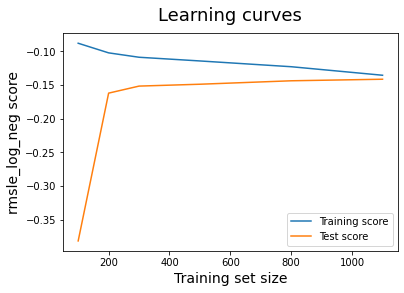

In [60]:
## Learning curves of search_model2.best_estimator_

estimator_model2 = search_model2.best_estimator_

train_sizes = [100, 200, 300, 500, 800, 1100]

# Get train scores, train sizes, and validation scores using `learning_curve`

y_log_train = pd.Series(y_train).apply(lambda x: math.log(x))

train_sizes, train_scores, test_scores = \
         learning_curve(estimator=estimator_model2, X=X_train, y=y_log_train, 
                        scoring=rmsle_log_neg, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('rmsle_log_neg score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

### Model 2.b   AdaBoost (Support Vector Regression)

- Model 2b adaboost: rmsle score = 0.15071633393438555, Delta vs baseline = -0.01560432843102097
- Model 2b adaboost best params => {'adaboost__loss': 'exponential', 'adaboost__n_estimators': 10}

In [61]:
# adaboost_base_estimator = SVR with best estimator params  
# best.estimator_ does not work as base_estimator for AdaBoost because it is already fitted
            
adaboost_regressor = AdaBoostRegressor(base_estimator = SVR(kernel=search_model2.best_params_['regressor__kernel'], 
                                        C=search_model2.best_params_['regressor__C'],
                                        epsilon=search_model2.best_params_['regressor__epsilon']))

pipe_baseline_adaboost = Pipeline([ ('transformer', preproc_iteration_2),
                                    ('adaboost',adaboost_regressor)], memory=cachedir)

adaboost_parameters = {'adaboost__n_estimators': (10, 20, 30, 40, 50),
                       'adaboost__loss': ["linear", "square", "exponential"]}

search_adaboost = GridSearchCV(pipe_baseline_adaboost, adaboost_parameters, cv = 5, 
                               scoring=rmsle_log_neg, n_jobs=-1)
search_adaboost.fit(X_train, y_log_train)

rmtree(cachedir)

In [63]:
adaboost_score = - search_adaboost.best_score_

print(f"Model 2 adaboost: rmsle score = {adaboost_score}, Delta vs baseline = {adaboost_score - score_baseline}")
print(f"Model 2 adaboost best params => {search_adaboost.best_params_}")

Model 2 adaboost: rmsle score = 0.15450689017673153, Delta vs baseline = -0.011812243219531005
Model 2 adaboost best params => {'adaboost__loss': 'exponential', 'adaboost__n_estimators': 10}


### Model 3 : Decision Tree Regression

- Model 3: rmsle score = 0.18154549548422536, Delta vs baseline = 0.015224833118818837
- Model 3 best params => {'regressor__max_depth': 18, 'regressor__min_samples_leaf': 9}

In [64]:
pipe_baseline_dtree = Pipeline([ ('transformer', preproc_iteration_2),
                    ('regressor', DecisionTreeRegressor(max_depth=15, min_samples_leaf=8)) ],
                    memory=cachedir)

cv_dtree = cross_validate(pipe_baseline_dtree, X_train_2, y_log_train_2, cv=5, scoring=rmsle_log_neg)

rmtree(cachedir)

model3_score = - cv_dtree['test_score'].mean() 
print(f"Model 3: rmsle score = {model3_score}, Delta vs baseline = {model3_score - score_baseline}")

Model 3: rmsle score = 0.18452309320471513, Delta vs baseline = 0.018203959808452602


In [65]:
grid_model3 = {'regressor__max_depth': stats.randint(5,20),
               'regressor__min_samples_leaf': stats.randint(5,10)}

search_model3 = RandomizedSearchCV(pipe_baseline_dtree, grid_model3, cv = 5, n_iter= 100, scoring=rmsle_log_neg, n_jobs=-1)

search_model3.fit(X_train_2, y_log_train_2)

rmtree(cachedir)

In [66]:
model3_score = - search_model3.best_score_

print(f"Model 3: rmsle score = {model3_score}, Delta vs baseline = {model3_score - score_baseline}")
print(f"Model 3 best params => {search_model3.best_params_}")

Model 3: rmsle score = 0.18219600256866017, Delta vs baseline = 0.01587686917239764
Model 3 best params => {'regressor__max_depth': 12, 'regressor__min_samples_leaf': 9}


### Model 4 : AdaBoost (DecisionTreeRegressor)

- Model 4 adaboost decision tree: rmsle score = 0.13942298626107166, Delta vs baseline = -0.026896147135190868
- Model 4 adaboost params 
> base_estimator = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10), loss="square",n_estimators=50

In [67]:
# adaboost_base_estimator = Decision Tree 

adaboost_regressor4 = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10))

pipe_baseline_adaboost4 = Pipeline([ ('transformer', preproc_iteration_2),
                                    ('adaboost',adaboost_regressor4)], memory=cachedir)

adaboost_parameters4 = {'adaboost__n_estimators': (20, 30, 40, 50),
                       'adaboost__loss': ["linear", "square"]}

search_adaboost4 = GridSearchCV(pipe_baseline_adaboost4, adaboost_parameters4, cv = 5, scoring=rmsle_log_neg, n_jobs=-1)

search_adaboost4.fit(X_train, y_log_train)

rmtree(cachedir)

In [68]:
adaboost4_score = - search_adaboost4.best_score_

print(f"Model 4 adaboost decision tree: rmsle score = {adaboost4_score}, Delta vs baseline = {adaboost4_score - score_baseline}")
print(f"Model 4 adaboost decision tree best params => {search_adaboost4.best_params_}")

Model 4 adaboost decision tree: rmsle score = 0.13942298626107166, Delta vs baseline = -0.026896147135190868
Model 4 adaboost decision tree best params => {'adaboost__loss': 'square', 'adaboost__n_estimators': 50}


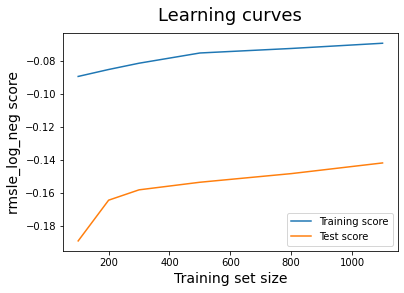

In [70]:
## Learning curves of search_model4.best_estimator_

estimator_model4 = search_adaboost4.best_estimator_

train_sizes = [100, 200, 300, 500, 800, 1100]

# Get train scores, train sizes, and validation scores using `learning_curve`

y_log_train = pd.Series(y_train).apply(lambda x: math.log(x))

train_sizes, train_scores, test_scores = \
         learning_curve(estimator=estimator_model4, X=X_train, y=y_log_train, 
                        scoring=rmsle_log_neg, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('rmsle_log_neg score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

### Model 5 : GradientBoostingRegressor

- Model 5: rmsle score = 0.12401223231779508, Delta vs baseline = -0.04230690107846745
- Model 5 best params => {'regressor__alpha': 0.15202758438591388, 'regressor__loss': 'ls', 'regressor__max_depth': 4, 'regressor__n_estimators': 191}

In [74]:
pipe_baseline_gboost = Pipeline([ ('transformer', preproc_iteration_2),
                                ('regressor', GradientBoostingRegressor(n_estimators=100)) ],
                               memory=cachedir)

cv_gboost = cross_validate(pipe_baseline_gboost, X_train_2, y_log_train_2, cv=5, scoring=rmsle_log_neg)

rmtree(cachedir)

model5_score = - cv_gboost['test_score'].mean() 
print(f"Model 5: rmsle score = {model5_score}, Delta vs baseline = {model5_score - score_baseline}")

Model 5: rmsle score = 0.12776962439501618, Delta vs baseline = -0.038549509001246346


In [75]:
grid_model5 = { 'regressor__alpha': stats.loguniform(0.1,2.0),
                'regressor__loss': ["ls", "huber", "quantile"],
                'regressor__max_depth': [3,4,5],
                'regressor__n_estimators': stats.randint(100,200)}
    
search_model5 = RandomizedSearchCV(pipe_baseline_gboost, grid_model5, cv = 5, n_iter= 200, scoring=rmsle_log_neg, n_jobs=-1)

search_model5.fit(X_train_2, y_log_train_2)

rmtree(cachedir)

/home/jm/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan -0.13336791 -0.13553145         nan
 -0.12454177 -0.14817269         nan -0.13308843 -0.13569073 -0.13426672
 -0.13016517 -0.13330789 -0.13624058 -0.13807635 -0.12455666 -0.1250695
 -0.1247234  -0.12980205 -0.12645439 -0.13164279 -0.13371265 -0.12547521
 -0.13342046         nan -0.12677607         nan         nan -0.12468609
         nan -0.13335475 -0.25194896         nan -0.13345996 -0.13210943
         nan -0.14085207 -0.1241711  -0.1315608  -0.14542752 -0.12626468
         nan -0.12701493 -0.13333176         nan         nan -0.12582962
 -0.13403434 -0.12523151 -0.12574104 -0.13345641         nan -0.1345798
 -0.13610248 -0.1547636  -0.17270021 -0.12585179         nan -0.19877419
 -0.14805847 -0.13188998 -0.1324485  -0.12631083 -0.13683377         nan
         nan -0.1456606    

In [76]:
model5_score = - search_model5.best_score_

print(f"Model 5: rmsle score = {model5_score}, Delta vs baseline = {model5_score - score_baseline}")
print(f"Model 5 best params => {search_model5.best_params_}")

Model 5: rmsle score = 0.12401223231779508, Delta vs baseline = -0.04230690107846745
Model 5 best params => {'regressor__alpha': 0.15202758438591388, 'regressor__loss': 'ls', 'regressor__max_depth': 4, 'regressor__n_estimators': 191}


### Model 6 : xgboost
- Model 6: rmsle score = 0.12891671585694828, Delta vs baseline = -0.03740241753931425
- n_estimators=300, learning_rate=0.05

In [126]:
pipe_baseline_xgboost = Pipeline([ ('transformer', preproc_iteration_2),
                                ('regressor', XGBRegressor(n_estimators=300, learning_rate=0.05)) ],
                                 memory=cachedir)

cv_xgboost = cross_validate(pipe_baseline_xgboost, X_train_2, y_log_train_2, cv=5, scoring=rmsle_log_neg)

rmtree(cachedir)

model6_score = - cv_xgboost['test_score'].mean() 
print(f"Model 6: rmsle score = {model6_score}, Delta vs baseline = {model6_score - score_baseline}")

Model 6: rmsle score = 0.12891671585694828, Delta vs baseline = -0.03740241753931425


In [95]:
# grid_model6 = { 'regressor__learning_rate': stats.loguniform(0.01, 1.5),
#                 'regressor__n_estimators': stats.randint(250,500)}

# search_model6 = RandomizedSearchCV(pipe_baseline_xgboost, grid_model6, cv = 5, n_iter=100, scoring=rmsle_log_neg, n_jobs=-1)

# search_model6.fit(X_train_2, y_log_train_2)

# rmtree(cachedir)

In [128]:
# model6_score = - search_model6.best_score_

# print(f"Model 6: rmsle score = {model6_score}, Delta vs baseline = {model6_score - score_baseline}")
# print(f"Model 6 best params => {search_model6.best_params_}")

# Making the prediction with VotingRegressor

>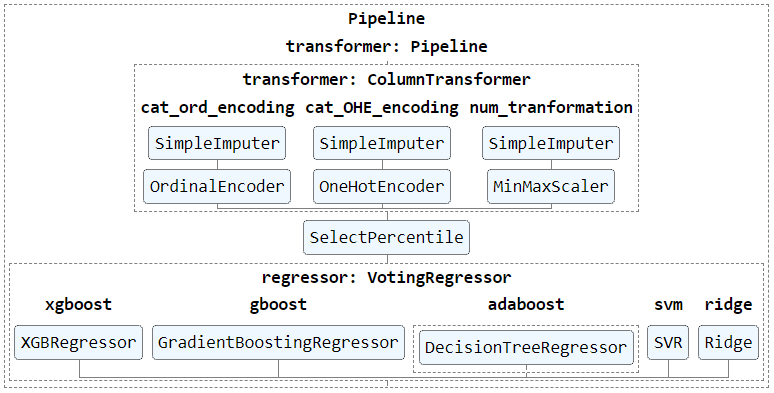
>
>|Weight 7a|Weight 7b|Stack of models|Params|
>| :-: | :-: | :- | :- |
>|1|2|XGBRegressor()|n_estimators=300, learning_rate=0.05|
>|1|3|GradientBoostingRegressor()|n_estimators=191, max_depth=4, loss="ls", alpha=0.15202758438591388|
>|1|2|AdaBoostRegressor()|base_estimator = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10),                      loss="square",n_estimators=50|
>|1|2|SVR()|C=0.24626481244539566, epsilon=0.08747649515484607, kernel="linear"|
>|1|1|Ridge()|alpha=2.2668622173975823|
>
>**Pipeline 7a - uniform weights**
>- rmsle score = 0.12425934704510803, Delta vs baseline = -0.042059786351154496 (Cross Validation of the training data)
>
>**Pipeline 7b - the better rmsle score the higher weight**
>- rmsle score = 0.12221600304529381, Delta vs baseline = -0.04410313035096872 (Cross Validation of the training data)
>- kaggle score = 0.12761 (Test data)

In [129]:
# Stacking the models

ridge = Ridge(alpha=2.2668622173975823)

svm = SVR(C=0.24626481244539566, epsilon=0.08747649515484607, kernel="linear")

adaboost = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10), 
                             loss="square",n_estimators=50)

gboost = GradientBoostingRegressor(n_estimators=191, max_depth=4, loss="ls", alpha=0.15202758438591388)

xgboost = XGBRegressor(n_estimators=300, learning_rate=0.05)

In [130]:
# Voting Regressor 7a - uniform weights

model7a = VotingRegressor( estimators = [("xgboost", xgboost),("gboost", gboost),("adaboost", adaboost),("svm", svm), 
                                        ("ridge", ridge)], weights = [1,1,1,1,1], n_jobs=-1 )

pipe_baseline_stacking_7a = Pipeline([ ('transformer', preproc_iteration_2),
                                    ('regressor', model7a ) ], memory=cachedir)

cv_stacking_7a = cross_validate(pipe_baseline_stacking_7a, X_train_2, y_log_train_2, cv=5,scoring=rmsle_log_neg)

rmtree(cachedir)

model7a_score = - cv_stacking_7a['test_score'].mean() 
print(f"Model 7a: rmsle score = {model7a_score}, Delta vs baseline = {model7a_score - score_baseline}")

Model 7a: rmsle score = 0.12425934704510803, Delta vs baseline = -0.042059786351154496


In [136]:
# Voting Regressor 7b

model7b = VotingRegressor( estimators = [("xgboost", xgboost),("gboost", gboost),("adaboost", adaboost),("svm", svm), 
                                        ("ridge", ridge)], weights = [2,3,2,2,1], n_jobs=-1 )

pipe_baseline_stacking_7b = Pipeline([ ('transformer', preproc_iteration_2),
                                    ('regressor', model7b ) ], memory=cachedir)

cv_stacking_7b = cross_validate(pipe_baseline_stacking_7b, X_train_2, y_log_train_2, cv=5,scoring=rmsle_log_neg)

rmtree(cachedir)

model7b_score = - cv_stacking_7b['test_score'].mean() 
print(f"Model 7b: rmsle score = {model7b_score}, Delta vs baseline = {model7b_score - score_baseline}")

Model 7b: rmsle score = 0.12221600304529381, Delta vs baseline = -0.04410313035096872


In [137]:
# Choosing the best model for predictions

# --- Pipeline stacking_7a

# best_model = pipe_baseline_stacking_7a
# file_name = "./data/submission_best_model_Voting_7a.csv"

# ---- Pipeline stacking_7b

best_model = pipe_baseline_stacking_7b
file_name = "./data/submission_best_model_Voting_7b.csv"

print("---------------------------")
print("Pipeline for the prediction")
print("---------------------------")

best_model

---------------------------
Pipeline for the prediction
---------------------------


Pipeline(memory='/tmp/tmp4dt566r5',
         steps=[('transformer',
                 Pipeline(memory='/tmp/tmp4dt566r5',
                          steps=[('transformer',
                                  ColumnTransformer(transformers=[('cat_ord_encoding',
                                                                   Pipeline(memory='/tmp/tmp4dt566r5',
                                                                            steps=[('cat_imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('cat_encoder',
                                                                                    OrdinalEncoder(categories=[['IR3',
                                                                                                                'IR2',
                                                                                                                'IR1',
                                                                                                                'Reg'],
                                                                                                               ['Low',
                                                                                                                'HLS',
                                                                                                                'Bnk'...
                                              GradientBoostingRegressor(alpha=0.15202758438591388,
                                                                        max_depth=4,
                                                                        n_estimators=191)),
                                             ('adaboost',
                                              AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20,
                                                                                                     min_samples_leaf=10),
                                                                loss='square')),
                                             ('svm',
                                              SVR(C=0.24626481244539566,
                                                  epsilon=0.08747649515484607,
                                                  kernel='linear')),
                                             ('ridge',
                                              Ridge(alpha=2.2668622173975823))],
                                 n_jobs=-1, weights=[2, 3, 2, 2, 1]))])

In [140]:
# Training the best model with the whole training data set

y_log_train = pd.Series(y_train).apply(lambda y: math.log(y))
best_model.fit(X_train,y_log_train)

# Making the prediction for the test data set

y_test_pred = pd.Series(best_model.predict(X_test)).apply(lambda y: math.exp(y))

# We create a dataframe with the predictions for the test data set

y_pred_best_model = pd.DataFrame(y_test_pred).rename(columns={0:'SalePrice'})
y_pred_best_model["Id"] = X_test["Id"]

# Let's compare with baseline predictions

y_pred = y_pred_best_model.set_index("Id").join(y_pred_baseline.set_index("Id"),lsuffix="_best",rsuffix="_base")
y_pred.sample(20, axis=0).T

Id,1625,1730,2494,1994,2806,1610,2248,2026,2624,1754,1972,2406,1510,2153,1537,2505,1697,1993,1839,1549
SalePrice_best,119281.276378,160337.128374,161093.625424,238031.636076,83798.440364,153686.291441,123051.660755,178531.238615,306265.162311,190177.909583,362687.417439,142232.309869,143412.782684,167406.753669,64829.391818,225929.714306,171162.084027,174943.420759,83996.066577,109766.784166
SalePrice_base,109716.274540,160143.976392,156337.053682,238088.938102,71819.636419,146866.878279,123350.855682,183460.541414,306463.325412,192958.028693,356379.740084,139048.557116,136716.466497,191331.394525,26402.713612,220376.595608,174352.927749,185257.195012,96863.815020,108544.972758


# 🏅SUBMISSION 

Discover your real test score by submitting your prediction to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

>- First submit "submission_best_model.csv" >> Kaggle score = 0.14041, Position leaderboard = 3158
>- Second submit "submission_best_model5.csv" >> Kaggle score = 0.13535, Position leaderboard = 2648
>- Third submit "submission_best_model5_V2.csv" >> Kaggle score = 0.13583
>- Fourth submit "submission_best_model_Voting.csv" >> Kaggle score = 0.12880, Position leaderboard = 1813
>- Fifth submit "submission_best_model_Voting_7b.csv" >> Kaggle score = 0.12761, Position leaderboard = 1686 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1bVNoHRxTP6-xZg4ALfpoznH9AX9U8xKCzFk2dY5RVkE/edit?usp=sharing) (pick the correct batch!)

In [141]:
file_name

'./data/submission_best_model_Voting_7b.csv'

In [144]:
# df.to_csv("./data/submission_baseline.csv",index=False,columns=columns_to_write,mode="w")

columns_to_write = ["Id","SalePrice"]

csv_ready_to_submit (y_pred_best_model, columns_to_write, file_name)

print("------------------------------------------------------------------------")
print(f"{file_name} is ready to be submitted")
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
./data/submission_best_model_Voting_7b.csv is ready to be submitted
------------------------------------------------------------------------
